In [1]:
# setting device on GPU if available, else CPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import numpy as np
import os
import torch.nn as nn
from tqdm import tqdm
import json
from functools import partial
from torch import einsum, nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from einops import pack, rearrange, reduce, repeat, unpack


In [4]:
def findAllFile(base):
    file_path = []
    for root, ds, fs in os.walk(base, followlinks=True):
        for f in fs:
            fullname = os.path.join(root, f)
            file_path.append(fullname)
    return file_path



In [5]:
# from utils.motion_processing.hml_process import recover_from_ric, recover_root_rot_pos,recover_from_rot
import utils.vis_utils.plot_3d_global as plot_3d
import matplotlib.pyplot as plt

def vis(mot , dset , name = "motion"):

    if isinstance(mot , torch.Tensor):
        mot = dset.toMotion(mot)
    mot =dset.inv_transform(mot)



    xyz = np.array(dset.to_xyz(mot).cpu())

    print(xyz.shape)

    
    plot_3d.render(xyz , f"/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/{name}.gif")

## VQVAE

In [8]:
from configs.config import cfg, get_cfg_defaults

vcfg = get_cfg_defaults()
vcfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/vqvae/vqvae_rv/vqvae_rv.yaml")

In [9]:
from core.datasets.conditioner import ConditionProvider, ConditionFuser
from core.datasets.multimodal_dataset import MotionAudioTextDataset, load_dataset, simple_collate

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from core.models.attend import Attention
from core import AttentionParams
from core import AttentionParams, TranslationTransformerParams, PositionalEmbeddingParams, PositionalEmbeddingType, MotionRep, AudioRep, TextRep


In [9]:
from core.datasets.conditioner import ConditionProvider, ConditionFuser
# from core.datasets.multimodal_dataset import MotionAudioTextDataset, load_dataset, simple_collate
dataset_args = vcfg.dataset


condition_provider2 = ConditionProvider(
            motion_rep=MotionRep(dataset_args.motion_rep),
            motion_padding=dataset_args.motion_padding,

        )

In [10]:
from core.datasets.multimodal_dataset import MotionAudioTextDataset
from core.datasets.vq_dataset import VQSMPLXMotionDataset
from core.datasets.vq_dataset import load_dataset, simple_collate as simple_collate2
from core import Motion
from core.models.resnetVQ.vqvae import HumanVQVAE
from core.models.loss import ReConsLoss
from utils.motion_processing.skeleton import Skeleton, t2m_kinematic_chain , body_joints_id, t2m_raw_body_offsets

In [11]:
# dset = MotionAudioTextDataset("moyo" , "/srv/hays-lab/scratch/sanisetty3/motionx" ,motion_rep = "body" , hml_rep = "gprvc", split = "test"   )

In [12]:
dset = VQSMPLXMotionDataset("choreomaster" , "/srv/hays-lab/scratch/sanisetty3/motionx" ,motion_rep = "body" , hml_rep = "rv", split = "train" , window_size = 600  )

Total number of motions choreomaster: 34


In [13]:
test_ds, _, _ = load_dataset(
            dataset_args=dataset_args,
            split="test",
        )

Total number of motions animation: 2
Total number of motions humanml: 2944
Total number of motions perform: 16
Total number of motions GRAB: 67
Total number of motions idea400: 577
Total number of motions humman: 19
Total number of motions beat: 162
Total number of motions game_motion: 130
Total number of motions music: 148
Total number of motions aist: 61
Total number of motions fitness: 572
Total number of motions moyo: 9
Total number of motions choreomaster: 2
Total number of motions dance: 7
Total number of motions kungfu: 42
Total number of motions EgoBody: 49
Total number of motions HAA500: 17


In [14]:
train_loader = torch.utils.data.DataLoader(
        test_ds,
        100,
        # sampler=sampler,
        collate_fn=partial(simple_collate2 , conditioner = condition_provider2),
        # drop_last=True,
    )

In [15]:
for inputs in train_loader:
    break
    

In [62]:
dset.render_hml(mot[0] , "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/r.gif")

In [16]:
vqvae_args = vcfg.vqvae
vqvae_args.nb_joints = test_ds.datasets[0].nb_joints
vqvae_args.motion_dim = test_ds.datasets[0].motion_dim
hml_rep = test_ds.datasets[0].hml_rep
motion_rep = test_ds.datasets[0].motion_rep


In [7]:
vqvae_args = vcfg.vqvae
vqvae_args.nb_joints = 22
vqvae_args.motion_dim = 192


In [43]:

# loss_fnc = ReConsLoss("l1_smooth" , True , vqvae_args.nb_joints , hml_rep=hml_rep , motion_rep = motion_rep  )
# loss_fnc2 = ReConsLoss("l1_smooth" , False , vqvae_args.nb_joints , hml_rep=hml_rep , motion_rep = motion_rep  )

In [8]:
vqvae_args

CfgNode({'target': 'core.models.resnetVQ.vqvae.HumanVQVAE2', 'nb_joints': 22, 'motion_dim': 192, 'dim': 768, 'depth': 6, 'dropout': 0.1, 'down_sampling_ratio': 4, 'conv_kernel_size': 5, 'rearrange_output': False, 'heads': 8, 'codebook_dim': 512, 'codebook_size': 1024, 'num_quantizers': 2, 'quantize_dropout_prob': 0.2, 'shared_codebook': False, 'sample_codebook_temp': 0.4, 'commit': 0.25, 'loss_vel': 1.0, 'loss_motion': 2.0, 'recons_loss': 'l1_smooth', 'use_geodesic_loss': False})

In [45]:
from core.models.resnetVQ.vqvae import HumanVQVAE2
vqvae_model = HumanVQVAE2(vqvae_args).to(device)
# vqvae_model.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/vqvae/vqvae_rv/vqvae_motion.pt")

Sync is turned on False


In [21]:
from core.models.resnetVQ.vqvae import HumanVQVAE
vqvae_model = HumanVQVAE(vqvae_args).to(device)
# vqvae_model.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/vqvae/vqvae_body/vqvae_motion_rv.pt")

In [11]:
vqvae_model.vqvae.quantizer.codebook.shape

torch.Size([1024, 512])

In [22]:
out = vqvae_model(
            motion=torch.randn((10 , 100 , 192)).to(device),
            # mask=mask,
        )

torch.Size([250, 512])
torch.Size([1250, 512])


In [48]:
loss_motion = loss_fnc(
            out.decoded_motion, gt_motion, mask=None
        )

loss_motion2 = loss_fnc2(
            out.decoded_motion, gt_motion, mask=None
        )

In [50]:

vqvae_model.eval()
val_loss_ae = {}
cnt = 0
codebook_usage = {i: 0 for i in range(vqvae_args.codebook_size )}
with torch.no_grad():
    for batch in tqdm(
        (train_loader),
        position=0,
        leave=True,
    ):
        gt_motion = batch["motion"][0].to(device)

        # indices = vqvae_model.encode(
        #     motion=gt_motion,
        #     # mask=mask,
        # )

        # used_indices = indices.flatten().tolist()
        out = vqvae_model(
            motion=gt_motion,
            # mask=mask,
        )

        out.perplexity = vqvae_model.vqvae.quantizer.compute_perplexity(out.indices.flatten())
        print(out.perplexity)

        used_indices = out.indices.flatten().tolist()
        unique_indices, counts = torch.unique(out.indices.flatten(), return_counts=True)
        for idx, count in zip(unique_indices, counts):
            codebook_usage[idx.item()] += count.item()
        usage = len(set(used_indices)) / vqvae_args.codebook_size 
        # print(out.perplexity)

        loss_dict = {
            # "total_loss": loss.detach().cpu(),
            # "loss_motion": loss_motion.detach().cpu(),
            # "commit_loss": vqvae_output.commit_loss.detach().cpu(),
            "usage": usage,
            "perplexity": out.perplexity
        }

        cnt+=1

        for key, value in loss_dict.items():
            if key in val_loss_ae:
                val_loss_ae[key] += value
            else:
                val_loss_ae[key] = value


for key in val_loss_ae.keys():
    val_loss_ae[key] = val_loss_ae[key] / cnt

total_usage = sum(codebook_usage.values())
average_usage_per_index = total_usage / vqvae_args.codebook_size 


  2%|█▊                                                                                       | 1/49 [00:00<00:10,  4.47it/s]

tensor(289.9571, device='cuda:0')


  4%|███▋                                                                                     | 2/49 [00:00<00:10,  4.61it/s]

tensor(287.7314, device='cuda:0')


  6%|█████▍                                                                                   | 3/49 [00:00<00:09,  4.74it/s]

tensor(316.6711, device='cuda:0')


  8%|███████▎                                                                                 | 4/49 [00:00<00:09,  4.77it/s]

tensor(343.8243, device='cuda:0')


 10%|█████████                                                                                | 5/49 [00:01<00:09,  4.83it/s]

tensor(271.9930, device='cuda:0')


 12%|██████████▉                                                                              | 6/49 [00:01<00:08,  4.86it/s]

tensor(307.7598, device='cuda:0')


 14%|████████████▋                                                                            | 7/49 [00:01<00:08,  4.80it/s]

tensor(312.7512, device='cuda:0')


 16%|██████████████▌                                                                          | 8/49 [00:01<00:08,  4.84it/s]

tensor(291.0934, device='cuda:0')


 18%|████████████████▎                                                                        | 9/49 [00:01<00:08,  4.86it/s]

tensor(305.5509, device='cuda:0')


 20%|█████████████████▉                                                                      | 10/49 [00:02<00:07,  4.88it/s]

tensor(321.3210, device='cuda:0')


 22%|███████████████████▊                                                                    | 11/49 [00:02<00:07,  4.85it/s]

tensor(278.0258, device='cuda:0')


 24%|█████████████████████▌                                                                  | 12/49 [00:02<00:07,  4.84it/s]

tensor(326.5566, device='cuda:0')
tensor(301.1002, device='cuda:0')


 29%|█████████████████████████▏                                                              | 14/49 [00:02<00:07,  4.94it/s]

tensor(310.6176, device='cuda:0')


 31%|██████████████████████████▉                                                             | 15/49 [00:03<00:06,  4.94it/s]

tensor(302.9529, device='cuda:0')
tensor(302.5337, device='cuda:0')


 35%|██████████████████████████████▌                                                         | 17/49 [00:03<00:06,  4.89it/s]

tensor(289.6815, device='cuda:0')


 37%|████████████████████████████████▎                                                       | 18/49 [00:03<00:06,  4.86it/s]

tensor(303.2496, device='cuda:0')


 39%|██████████████████████████████████                                                      | 19/49 [00:03<00:06,  4.87it/s]

tensor(319.4746, device='cuda:0')


 41%|███████████████████████████████████▉                                                    | 20/49 [00:04<00:05,  4.88it/s]

tensor(300.9641, device='cuda:0')
tensor(295.6805, device='cuda:0')


 45%|███████████████████████████████████████▌                                                | 22/49 [00:04<00:05,  4.89it/s]

tensor(330.6924, device='cuda:0')
tensor(261.9393, device='cuda:0')


 49%|███████████████████████████████████████████                                             | 24/49 [00:04<00:05,  4.93it/s]

tensor(319.2980, device='cuda:0')


 51%|████████████████████████████████████████████▉                                           | 25/49 [00:05<00:04,  4.94it/s]

tensor(270.3061, device='cuda:0')
tensor(312.0115, device='cuda:0')


 55%|████████████████████████████████████████████████▍                                       | 27/49 [00:05<00:04,  4.98it/s]

tensor(293.3038, device='cuda:0')


 57%|██████████████████████████████████████████████████▎                                     | 28/49 [00:05<00:04,  4.96it/s]

tensor(318.7498, device='cuda:0')


 59%|████████████████████████████████████████████████████                                    | 29/49 [00:05<00:04,  4.93it/s]

tensor(321.1425, device='cuda:0')


 61%|█████████████████████████████████████████████████████▉                                  | 30/49 [00:06<00:03,  4.89it/s]

tensor(286.0846, device='cuda:0')


 63%|███████████████████████████████████████████████████████▋                                | 31/49 [00:06<00:03,  4.82it/s]

tensor(350.6438, device='cuda:0')


 65%|█████████████████████████████████████████████████████████▍                              | 32/49 [00:06<00:03,  4.78it/s]

tensor(358.3927, device='cuda:0')


 67%|███████████████████████████████████████████████████████████▎                            | 33/49 [00:06<00:03,  4.80it/s]

tensor(339.0778, device='cuda:0')


 69%|█████████████████████████████████████████████████████████████                           | 34/49 [00:06<00:03,  4.82it/s]

tensor(336.7331, device='cuda:0')


 71%|██████████████████████████████████████████████████████████████▊                         | 35/49 [00:07<00:02,  4.82it/s]

tensor(334.9448, device='cuda:0')


 73%|████████████████████████████████████████████████████████████████▋                       | 36/49 [00:07<00:02,  4.81it/s]

tensor(398.1593, device='cuda:0')


 76%|██████████████████████████████████████████████████████████████████▍                     | 37/49 [00:07<00:02,  4.01it/s]

tensor(170.7106, device='cuda:0')


 78%|████████████████████████████████████████████████████████████████████▏                   | 38/49 [00:08<00:03,  3.49it/s]

tensor(174.4048, device='cuda:0')


 80%|██████████████████████████████████████████████████████████████████████                  | 39/49 [00:08<00:02,  3.79it/s]

tensor(388.8571, device='cuda:0')


 82%|███████████████████████████████████████████████████████████████████████▊                | 40/49 [00:08<00:02,  4.04it/s]

tensor(178.0180, device='cuda:0')


 84%|█████████████████████████████████████████████████████████████████████████▋              | 41/49 [00:08<00:01,  4.16it/s]

tensor(312.0809, device='cuda:0')


 86%|███████████████████████████████████████████████████████████████████████████▍            | 42/49 [00:08<00:01,  4.34it/s]

tensor(450.4752, device='cuda:0')


 88%|█████████████████████████████████████████████████████████████████████████████▏          | 43/49 [00:09<00:01,  4.49it/s]

tensor(365.2820, device='cuda:0')


 90%|███████████████████████████████████████████████████████████████████████████████         | 44/49 [00:09<00:01,  4.61it/s]

tensor(343.7886, device='cuda:0')
tensor(379.5918, device='cuda:0')


 94%|██████████████████████████████████████████████████████████████████████████████████▌     | 46/49 [00:09<00:00,  4.89it/s]

tensor(325.9454, device='cuda:0')
tensor(386.7509, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████████████| 49/49 [00:10<00:00,  4.79it/s]

tensor(399.3810, device='cuda:0')
tensor(156.6232, device='cuda:0')


In [51]:
val_loss_ae

{'usage': 0.5695153061224489, 'perplexity': tensor(311.0792, device='cuda:0')}

In [38]:
average_usage_per_index

141.328125

In [39]:
np.median(list(codebook_usage.values()))

99.0

<BarContainer object of 1024 artists>

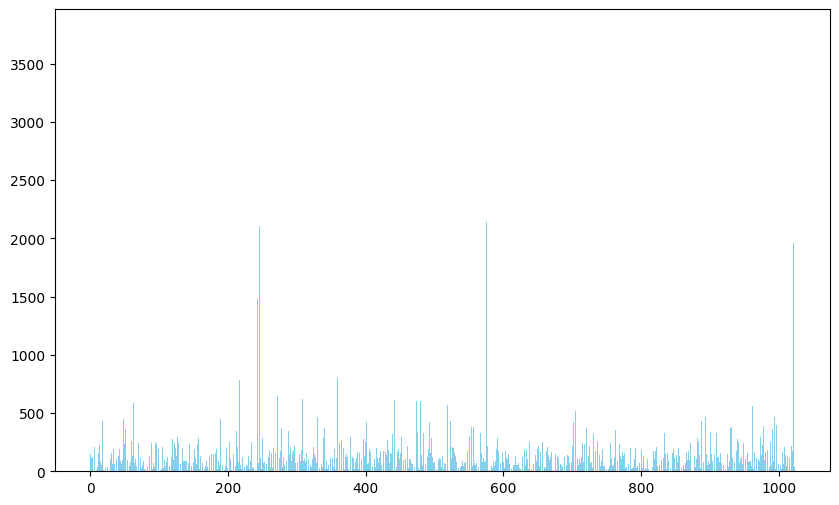

In [40]:
indices = list(codebook_usage.keys())
usage_counts = list(codebook_usage.values())

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(indices, usage_counts, color='skyblue')

In [45]:
val_loss_ae

{'usage': 0.6187420280612245, 'perplexity': tensor(381.2243, device='cuda:0')}

In [46]:
average_usage_per_index

141.328125

In [47]:
np.median(list(codebook_usage.values()))

115.0

<BarContainer object of 1024 artists>

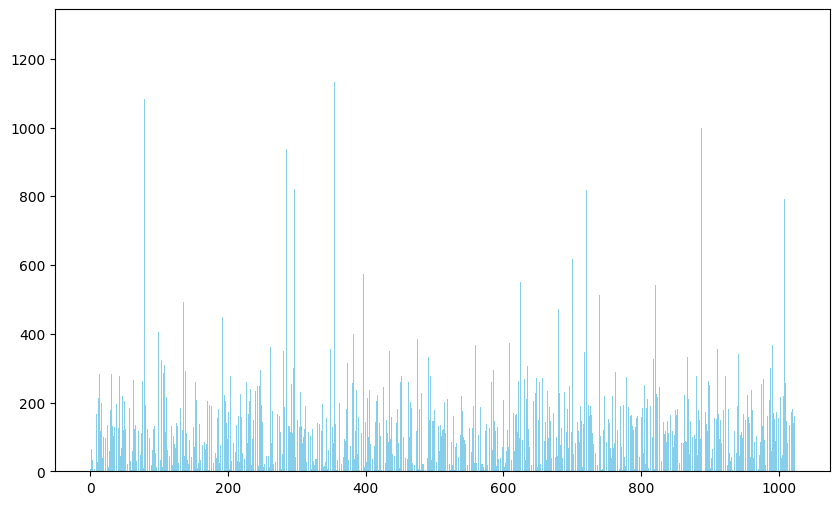

In [48]:
indices = list(codebook_usage.keys())
usage_counts = list(codebook_usage.values())

# Plot the graph
plt.figure(figsize=(10, 6))
plt.bar(indices, usage_counts, color='skyblue')

In [13]:
data.shape

torch.Size([768000])

In [18]:
embed.shape

torch.Size([1024, 768000])

In [20]:
cluster_size.shape

torch.Size([1024])

In [23]:
embed_sum = embed * rearrange(cluster_size, "... -> ... 1")

In [25]:
embed_sum.shape

torch.Size([1024, 768000])

## Motion Gen

In [9]:
from core import MotionRep, AudioRep, TextRep
from core.datasets.conditioner import ConditionProvider, ConditionFuser
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
from core.models.generation.motion_generator import Transformer, MotionMuse
from core.models.utils import instantiate_from_config, get_obj_from_str


In [10]:
from configs.config_t2m import cfg, get_cfg_defaults
from configs.config import get_cfg_defaults as get_cfg_defaults3

cfg = get_cfg_defaults()
cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_generation/motion_generation.yaml")
cfg.freeze()
mmuse_args = cfg.motion_generator
dataset_args = cfg.dataset


KeyError: 'Non-existent config key: codebooks_pattern'

In [3]:
target = mmuse_args.pop("target")
motion_muse = MotionMuse(mmuse_args).to(device).eval()

NameError: name 'device' is not defined

In [9]:
from core.models.resnetVQ.vqvae import HumanVQVAE

In [57]:

vcfg = get_cfg_defaults3()
vcfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/vqvae/vqvae_body_gprvc/vqvae_body_gprvc.yaml")
vqvae_args = vcfg.vqvae
vqvae_args.nb_joints = 22
vqvae_args.motion_dim = 263

In [ ]:
np.split(np.cusum)

In [14]:
vqvae_model = HumanVQVAE(vqvae_args).to(device).eval()
vqvae_model.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ACMG/checkpoints/smplx_resnet/vqvae_motion.pt")

In [10]:
condition_provider = ConditionProvider(
            motion_rep=MotionRep(dataset_args.motion_rep),
            audio_rep=AudioRep(dataset_args.audio_rep),
            text_rep=TextRep(dataset_args.text_rep),
            motion_padding=dataset_args.motion_padding,
            audio_padding=dataset_args.audio_padding,
            motion_max_length_s=10,
            audio_max_length_s=10,
            pad_id = motion_muse.transformer.pad_token_id,
            fps=30/4
        )

In [14]:
bod_ind = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/indices/body/aist/subset_0000/Dance_Break_3_Step_clip_1.npy")
lh_ind = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/indices/left_hand/aist/subset_0000/Dance_Break_3_Step_clip_1.npy")
rh_ind = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/indices/right_hand/aist/subset_0000/Dance_Break_3_Step_clip_1.npy")

In [53]:
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate

dset = MotionIndicesAudioTextDataset("animation" , "/srv/hays-lab/scratch/sanisetty3/motionx" ,motion_rep = "full", split = "train" , fps = 30/4  )

Total number of motions animation: 268 and texts 268


In [54]:
inpss  = next(iter(dset))

In [58]:
train_ds, sampler_train, weights_train  = load_dataset_gen(dataset_args=dataset_args, split = "train" , dataset_names = ["animation" , "choreomaster" ] )

Total number of motions animation: 73 and texts 73
Total number of motions choreomaster: 34 and texts 34


In [59]:
train_loader = torch.utils.data.DataLoader(
        dset,
        4,
        # sampler=sampler_train,
        # shuffle = False,
        collate_fn=partial(simple_collate , conditioner = condition_provider),
        drop_last=True,
    )

In [60]:
for inputs, conditions in train_loader:
    break
    

In [14]:
inputs["motion"][0].shape

torch.Size([4, 75, 3])

In [57]:
inputs["motion"][1].shape

torch.Size([4, 75])

In [58]:
conditions["audio"][0].shape

torch.Size([4, 500, 128])

In [59]:
conditions["text"][0].shape

torch.Size([4, 1, 768])

In [35]:
motions = inputs["motion"][0].squeeze().to(torch.long)
motion_mask = inputs["motion"][1]

In [164]:
fuse_method = {"cross": ["audio"], "prepend": ["text"]}
condition_fuser = ConditionFuser(fuse_method)

In [ ]:
audio_embed = self.project_audio(conditions["audio"][0])
text_embed = self.project_text(conditions["text"][0])

inputs_, cross_inputs = self.condition_fuser(
    input,
    {
        "text": (text_embed, conditions["text"][1]),
        "audio": (audio_embed, conditions["audio"][1]),
    },
)

torch.Size([4, 75, 1])

## MotionMuse

In [36]:
loss , logits = motion_muse((motions , motion_mask) , conditions , cond_drop_prob = 0.4 , return_logits = True)

In [79]:
pred_indices = lologits.argmax(-1)
pred_motion  = vqvae_model.decode(pred_indices[:1])

In [65]:
mod_motion = torch.where(motions >= 1024 , 0 , motions)
gt_motion  = vqvae_model.decode(mod_motion)

In [71]:
gt_motion[1].shape

torch.Size([300, 263])

In [66]:
dset.render_hml(
                    gt_motion[1][:(int(sum(motion_mask[1])) *4)].detach().squeeze().cpu(),
                    "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/gt_motion_recon.gif"
                )

In [ ]:
logits2 = motion_muse.transformer.forward_with_cond_scale((motions , motion_mask) , conditions)
logits3 =motion_muse.transformer.forward_with_neg_prompt((motions , motion_mask) , conditions , conditions)

In [48]:
motions.shape

torch.Size([4, 28])

In [49]:
28*4

112

In [67]:
gen_ids = motion_muse.generate(conditions)

100%|█████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 14.65it/s]


## Streaming transformer

In [6]:

from core.param_dataclasses import pattern_providers
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
from core.models.utils import instantiate_from_config, get_obj_from_str


/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [86]:
from core import MotionRep, AudioRep, TextRep
from core.datasets.conditioner import ConditionProvider,ConditionFuser
from core.models.generation.lm import LMModel, MotionGen

In [95]:
from configs.config_streaming import cfg, get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_streaming/motion_streaming.yaml")
# cfg.freeze()

In [96]:
cfg.transformer_lm.custom = True

In [97]:
lm_args = cfg.transformer_lm
target = lm_args.pop("target")
fuse_config = cfg.fuser
pattern_args = cfg.codebooks_pattern
dataset_args = cfg.dataset

In [29]:
model_gen= MotionGen(lm_args , fuse_config , pattern_args ).to(device)

In [98]:
modeling = pattern_args.pop("modeling")
pattern_provider = pattern_providers[modeling](lm_args.n_q, delays = pattern_args.delays , flatten_first = pattern_args.flatten_first , empty_initial = pattern_args.empty_initial )

In [99]:
fuse_method = fuse_config.pop("fuse_method")
if isinstance(fuse_method, list):
    fuse_method = fuse_method[0]
condition_fuser = ConditionFuser(fuse_method, **fuse_config)

In [100]:
model = LMModel(
            pattern_provider=pattern_provider,
            fuser=condition_fuser,
            **lm_args
        ).to(device)

In [103]:
import time
start = time.time()
for i in range(100):
    out = model.compute_predictions(inputs["motion"] , conditions)
end = time.time()
print('custom attention took {} seconds'.format(end - start))

custom attention took 0.5189828872680664 seconds


In [14]:
import typing as tp
def _compute_cross_entropy(
     logits: torch.Tensor, targets: torch.Tensor, mask: torch.Tensor
) -> tp.Tuple[torch.Tensor, tp.List[torch.Tensor]]:
    """Compute cross entropy between multi-codebook targets and model's logits.
    The cross entropy is computed per codebook to provide codebook-level cross entropy.
    Valid timesteps for each of the codebook are pulled from the mask, where invalid
    timesteps are set to 0.

    Args:
        logits (torch.Tensor): Model's logits of shape [B, K, T, card].
        targets (torch.Tensor): Target codes, of shape [B, K, T].
        mask (torch.Tensor): Mask for valid target codes, of shape [B, K, T].
    Returns:
        ce (torch.Tensor): Cross entropy averaged over the codebooks
        ce_per_codebook (list of torch.Tensor): Cross entropy per codebook (detached).
    """
    B, K, T = targets.shape
    assert logits.shape[:-1] == targets.shape
    assert mask.shape == targets.shape
    ce = torch.zeros([], device=targets.device)
    ce_per_codebook: tp.List[torch.Tensor] = []
    for k in range(K):
        logits_k = (
            logits[:, k, ...].contiguous().view(-1, logits.size(-1))
        )  # [B x T, card]
        targets_k = targets[:, k, ...].contiguous().view(-1)  # [B x T]
        mask_k = mask[:, k, ...].contiguous().view(-1)  # [B x T]
        ce_targets = targets_k[mask_k]
        ce_logits = logits_k[mask_k]
        q_ce = F.cross_entropy(ce_logits, ce_targets)
        ce += q_ce
        ce_per_codebook.append(q_ce.detach())
    # average cross entropy across codebooks
    ce = ce / K
    return ce, ce_per_codebook



In [13]:
condition_provider = ConditionProvider(
            motion_rep=MotionRep(dataset_args.motion_rep),
            audio_rep=AudioRep(dataset_args.audio_rep),
            text_rep=TextRep(dataset_args.text_rep),
            motion_padding=dataset_args.motion_padding,
            audio_padding=dataset_args.audio_padding,
            motion_max_length_s=10,
            audio_max_length_s=10,
            pad_id = model.pad_token_id,
            fps=30/4,
            # device = "cpu"
        )

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [14]:
from core.datasets.multimodal_dataset import MotionIndicesAudioTextDataset, load_dataset_gen, simple_collate
dset = MotionIndicesAudioTextDataset("animation" , "/srv/hays-lab/scratch/sanisetty3/motionx" ,motion_rep = "full", split = "train" , fps = 30/4  )


Total number of motions animation: 268 and texts 268


In [15]:
# train_ds, sampler_train, weights_train  = load_dataset_gen(dataset_args=dataset_args, split = "train" , dataset_names = ["animation" , "choreomaster" ] )
train_loader = torch.utils.data.DataLoader(
        dset,
        4,
        # sampler=sampler_train,
        # shuffle = False,
        collate_fn=partial(simple_collate , conditioner = condition_provider , permute = True),
        drop_last=True,
    )

In [16]:
for inputs, conditions in train_loader:
    break
    

In [17]:
input_mask = inputs["motion"][1]
motions_or_ids = inputs["motion"][0]
B, K, T = motions_or_ids.shape

In [18]:
conditions["text"][0].shape

torch.Size([4, 1, 768])

In [19]:
conditions["audio"][0].shape

torch.Size([4, 1, 128])

In [30]:
logits, loss, ce_per_codebook = model_gen(inputs["motion"] , conditions, return_logits = True)

In [128]:
for inputs, conditions in train_loader:
    break
    

In [22]:
q = torch.randn((4, 54, 512))

In [85]:
# attn_mas(query.shape[1], query.device, query.dtype)

In [81]:
def create_causal_mask(i, j=None, device="cuda"):
    if j is not None and i != j:
        mask = torch.zeros((i, j), device=device, dtype=torch.bool)

        scale = j / i

        # num_masked_elements = torch.arange(
        #     int(round(scale)), int(round(scale * i)) + 1, int(round(scale))
        # )
        strt = 1 if scale < 1 else int(round(scale))
        num_masked_elements = torch.linspace(strt, j + 1, i)

        for idx, num in enumerate(num_masked_elements[:i]):

            mask[idx, int(num) :] = True
        return mask

    return torch.ones((i, i), device=device, dtype=torch.bool).triu(i - i + 1)

In [82]:
attn_mask = create_causal_mask(3, device = "cuda")
key_padding_mask = input_mask

In [83]:
attn_mask

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]], device='cuda:0')

In [45]:
mask_value = -torch.finfo(torch.float).max

In [68]:
key_padding_mask = rearrange(key_padding_mask, "b j -> b 1 1 j")

In [69]:
attn_mask = repeat(attn_mask, "i j -> b 1 i j", b=4)

In [78]:
key_padding_mask2 = torch.where(~key_padding_mask , mask_value , 0  )
attn_mask2 = torch.where(attn_mask , float("-inf") , 0  )

In [80]:
attn_mask2.to(torch.bool)

tensor([[False,  True,  True],
        [False, False,  True],
        [False, False, False]], device='cuda:0')

In [93]:
import time
start = time.time()
for i in range(1):
    out = model.compute_predictions(inputs["motion"] , conditions)
end = time.time()
print('custom attention took {} seconds'.format(end - start))

torch.Size([4, 54, 512]) torch.Size([4, 54, 512])
torch.Size([54, 54]) torch.float32
torch.Size([4, 54]) torch.bool


TypeError: _get_mask() got multiple values for argument 'device'

In [55]:
import time
start = time.time()
for i in range(100):
    out = model.compute_predictions(inputs["motion"] , conditions)
end = time.time()
print('torch attention took {} seconds'.format(end - start))

torch attention took 0.45839786529541016 seconds


In [76]:
loss

tensor(7.4837, device='cuda:0', grad_fn=<DivBackward0>)

In [77]:
ce_per_codebook

[tensor(7.6227, device='cuda:0'),
 tensor(7.1723, device='cuda:0'),
 tensor(7.6560, device='cuda:0')]

In [51]:
target = torch.where(motions_or_ids == 1024 , -100 , motions_or_ids)

In [53]:
mask = (
            input_mask.unsqueeze(1).expand(-1, K, -1).contiguous() & out.mask
        )

In [56]:
ce, ce_per_codebook = _compute_cross_entropy(out.logits, target, mask)

In [57]:
ce

tensor(7.5305, device='cuda:0', grad_fn=<DivBackward0>)

In [58]:
ce_per_codebook

[tensor(7.4742, device='cuda:0'),
 tensor(7.8424, device='cuda:0'),
 tensor(7.2748, device='cuda:0')]

In [35]:
model_cfg = cfg_s.transformer_lm

In [36]:
params = MotionTokenizerParams(model_cfg.card)

In [40]:
n_q = 3
codes = inputs["motion"][0].permute(0,2,1).to(torch.long)
code_mask = inputs["motion"][1]

In [41]:
B, K, T = codes.shape
codes = codes.contiguous()

In [42]:
codes.shape

torch.Size([4, 3, 52])

In [43]:
pattern = pattern_provider.get_pattern(T)

In [44]:
codes.shape

torch.Size([4, 3, 52])

In [46]:
sequence_codes, sequence_indexes, sequence_mask = (
            pattern.build_pattern_sequence(
                codes,
                1025,
                keep_only_valid_steps=True,
            )
)

In [48]:
sequence_codes.shape

torch.Size([4, 3, 53])

In [47]:
code_mask.shape

torch.Size([4, 52])

In [49]:
sequence_mask.shape

torch.Size([3, 53])

In [50]:
new_mask = torch.ones_like(sequence_mask).repeat(B , 1 , 1)
for i in range(n_q):
    new_mask[:,i,i+1:] = code_mask[:,0:T-i]

In [53]:
new_mask.shape

torch.Size([4, 3, 53])

In [56]:
new_new_mask = (new_mask.sum(1) == new_mask.shape[1])

In [59]:
new_new_mask[0]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False])

In [10]:
from core.datasets.audio_encoders import AudioConditionerEncodec, AudioConditionerLibrosa

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [44]:
audenc = AudioConditionerEncodec()
audlib = AudioConditionerLibrosa()

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [40]:
emb = audenc("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/choreomaster/0071.wav")

In [50]:
emb2 = audlib("/srv/hays-lab/scratch/sanisetty3/motionx/audio/wav/choreomaster/0071.wav")

In [51]:
emb2.shape

(5234, 35)

In [52]:
emb.shape

torch.Size([8722, 128])

In [53]:
emb1 = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/audio/encodec/choreomaster/0071.npy")

In [54]:
emb1.shape

(8722, 128)

128

In [46]:
import librosa

In [47]:
librosa.feature.chroma_cens()

NameError: name 'data' is not defined

In [78]:
logits = torch.randn((4 , 1024 , 3 , 53))

In [80]:
logits, logits_indexes, logits_mask = pattern.revert_pattern_logits(
            logits, float("nan"), keep_only_valid_steps=True
        )

In [101]:
logits_mask

tensor([[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
           True,  True,  True,  True,  True,  True,  True,  True,  Tru

In [82]:
logits.shape

torch.Size([4, 1024, 3, 52])

In [84]:
logits = logits.permute(0, 2, 3, 1)  # [B, K, T, card]
logits_mask = logits_mask[None, :, :].expand(B, -1, -1)

In [88]:
logits.shape

torch.Size([4, 3, 52, 1024])

## Inference

In [ ]:
text = "a man dancing"
audio = 

In [33]:
aud , am = condition_provider._get_audio_features(audio_list = [None])

In [34]:
aud.shape

(1, 1, 128)

In [82]:

sap = AttentionParams(dim = 256 , causal=True)
cap = AttentionParams(dim = 256 , causal=True , add_null_kv=True)
transformer_params = TranslationTransformerParams(self_attention_params = sap , 
                                                  cross_attention_params = cap , 
                                                  depth = 1, 
                                                  positional_embedding_params=PositionalEmbeddingParams(dim = 256) , 
                                                  positional_embedding=PositionalEmbeddingType.SINE,
                                                  fuse_method = {"cross_seperate" : ["audio" , "text"]}
                                                 )

In [87]:
embed = transformer_blocks(
            x=x_,
            mask=x_padding_mask,
            context=context,
            context_mask=context_padding_mask,
        )

In [89]:
embed = embed[:, -n:, :]

In [90]:
embed.shape

torch.Size([4, 116, 256])

In [ ]:
class FrozenCLIPEmbedder(nn.Module):
    """Uses the CLIP transformer encoder for text (from Hugging Face)"""
    def __init__(self, version="openai/clip-vit-large-patch14", device="cuda", max_length=77):
        super().__init__()
        self.tokenizer = CLIPTokenizer.from_pretrained(version)
        self.transformer = CLIPTextModel.from_pretrained(version)
        self.device = device
        self.max_length = max_length
        self.freeze()

    def freeze(self):
        self.transformer = self.transformer.eval()
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, text):
        batch_encoding = self.tokenizer(text, truncation=True, max_length=self.max_length, return_length=True,
                                        return_overflowing_tokens=False, padding="max_length", return_tensors="pt")
        tokens = batch_encoding["input_ids"].to(self.device)
        outputs = self.transformer(input_ids=tokens)

        z = outputs.last_hidden_state
        return z

    def encode(self, text):
        return self(text)

In [143]:
pos_emb = ScaledSinusoidalEmbedding(PositionalEmbeddingParams(dim = 256))

In [161]:
b , n , _ = input["motion"][0].shape

In [167]:

x = pos_emb(input["motion"][0]).repeat(b , 1 ,1)


In [173]:
x.shape

torch.Size([4, 116, 256])

In [ ]:
for a, (b , c) in conditions.items():
    print(a)
    print(b.shape)

In [175]:
inputs_ , cross_inputs = condition_fuser(x , conditions  )

In [176]:
inputs_.shape

torch.Size([4, 153, 256])

In [177]:
cross_inputs.shape

torch.Size([4, 500, 256])